In [4]:
import pandas_datareader as pdr
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import numpy as np
import scipy
import matplotlib.pyplot as plt

#### Get date time series from Yahoo! Finance for chosen tickers for the last 5 years from current date.  Note the ticker must present the full duration for this script.

In [19]:
years = 5
end_date = dt.datetime.now()
start_date = end_date - relativedelta(years=years)
close_price = pd.DataFrame()
tickers = ['ECL','ADSK','JPM','DIS','ATVI','JNJ']
for ticker in tickers:
    tmp = pdr.get_data_yahoo(ticker, start_date, end_date)
    close_price[ticker] = tmp['Close']

close_price.head()

,ECL,ADSK,JPM,DIS,ATVI,JNJ
Date,,,,,,
2016-05-26,118.199997,58.110001,65.029999,99.809998,39.099998,112.900002
2016-05-27,118.339996,59.340000,65.430000,100.290001,39.340000,113.059998
2016-05-31,117.239998,58.270000,65.269997,99.220001,39.259998,112.690002
2016-06-01,118.519997,58.299999,65.690002,98.519997,38.650002,112.779999
2016-06-02,118.870003,58.759998,65.809998,98.720001,38.689999,114.489998


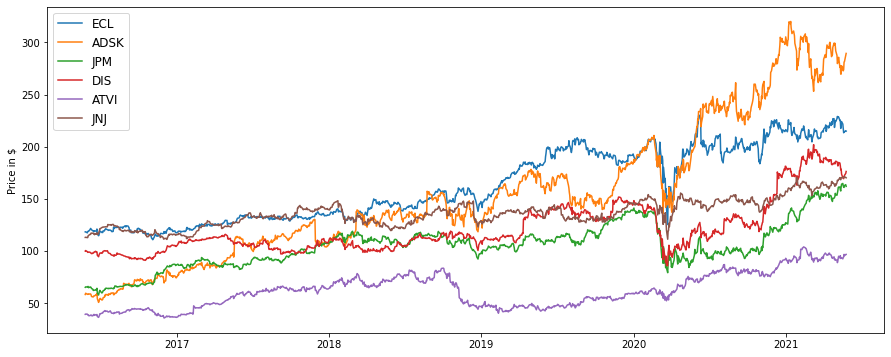

In [6]:
plt.figure(figsize=(15,6))
for i in range(close_price.shape[1]):
    plt.plot(close_price.iloc[:,i], label=close_price.columns.values[i])
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Price in $')
plt.show()


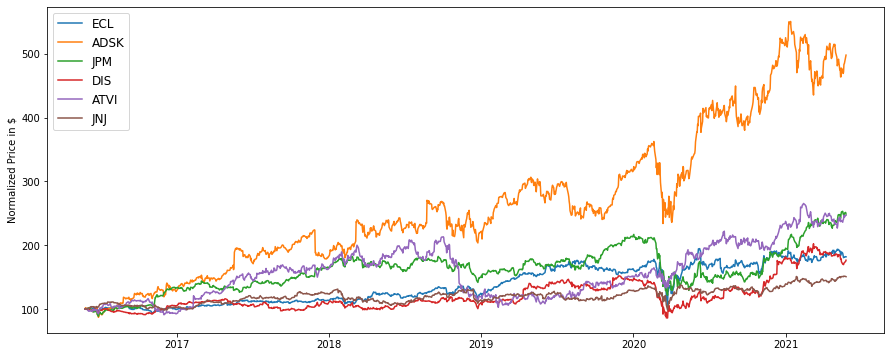

In [7]:
norm_price=close_price.divide(close_price.iloc[0]/100)
plt.figure(figsize=(15,6))
for i in range(norm_price.shape[1]):
    plt.plot(norm_price.iloc[:,i], label=norm_price.columns.values[i])
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Normalized Price in $')
plt.show()

In [10]:
#Calculate daily changes in the stocks' value
returns = close_price.pct_change()
#Remove nan values at the first row of df2. Create a new dataframe df
df=returns.iloc[1:len(returns.index),:]
# Calculate annualized average return for each stock. Annualized average return = Daily average return * 252 business days.
r = np.mean(df,axis=0)*252

# Create a covariance matrix
covar = df.cov()

In [11]:
#Define frequently used functions.
# r is each stock's return, w is the portion of each stock in our portfolio, and covar is the covariance matrix
# Rate of return
def ret(r,w):
    return r.dot(w)
# Risk level - or volatility
def vol(w,covar):
    return np.sqrt(np.dot(w,np.dot(w,covar)))
def sharpe (ret,vol):
    return ret/vol

In [14]:
# All weights, of course, must be between 0 and 1. Thus we set 0 and 1 as the boundaries.
from scipy.optimize import Bounds
bounds = Bounds(0, 1)

# The second boundary is the sum of weights.
from scipy.optimize import LinearConstraint
linear_constraint = LinearConstraint(np.ones((returns.shape[1],), dtype=int),1,1)

# Find a portfolio with the minimum risk.
from scipy.optimize import minimize
#Create x0, the first guess at the values of each stock's weight.
weights = np.ones(returns.shape[1])
x0 = weights/np.sum(weights)
#Define a function to calculate volatility
fun1 = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))
res = minimize(fun1,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds)

#These are the weights of the stocks in the portfolio with the lowest level of risk possible.
w_min = res.x

np.set_printoptions(suppress = True, precision=2)
print(w_min)
print('return: % .2f'% (ret(r,w_min)*100), 'risk: % .3f'% vol(w_min,covar))

[0.07 0.   0.02 0.17 0.13 0.6 ]
return:  13.63 risk:  0.011


#### TO THE MOON!!

In [15]:
#Define 1/Sharpe_ratio
fun2 = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))/r.dot(w)
res_sharpe = minimize(fun2,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds)

#These are the weights of the stocks in the portfolio with the highest Sharpe ratio.
w_sharpe = res_sharpe.x
print(w_sharpe)
print('return: % .2f'% (ret(r,w_sharpe)*100), 'risk: % .3f'% vol(w_sharpe,covar))

[0.   0.48 0.3  0.   0.2  0.02]
return:  30.72 risk:  0.017


In [17]:
w = w_min
num_ports = 100
gap = (np.amax(r) - ret(r,w_min))/num_ports

all_weights = np.zeros((num_ports, len(df.columns)))
all_weights[0],all_weights[1]=w_min,w_sharpe
ret_arr = np.zeros(num_ports)
ret_arr[0],ret_arr[1]=ret(r,w_min),ret(r,w_sharpe)
vol_arr = np.zeros(num_ports)
vol_arr[0],vol_arr[1]=vol(w_min,covar),vol(w_sharpe,covar)

for i in range(num_ports):
    port_ret = ret(r,w) + i*gap
    double_constraint = LinearConstraint([np.ones(price_2.shape[1]),r],[1,port_ret],[1,port_ret])
    
    #Create x0: initial guesses for weights.
    x0 = w_min
    #Define a function for portfolio volatility.
    fun = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))
    a = minimize(fun,x0,method='trust-constr',constraints = double_constraint,bounds = bounds)
    
    all_weights[i,:]=a.x
    ret_arr[i]=port_ret
    vol_arr[i]=vol(a.x,covar)
    
sharpe_arr = ret_arr/vol_arr 

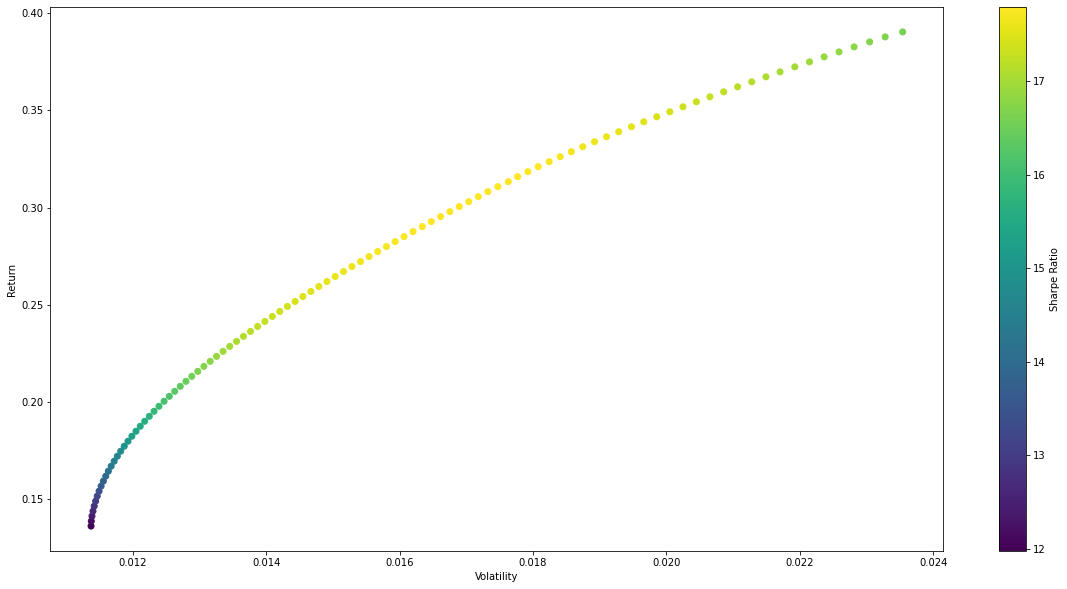

In [18]:
plt.figure(figsize=(20,10))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()